# The Oscars (Assignment # 07) EECS -731
---

**Quick Note:** Some content of this assignment (pre-processing and merging part) and my assignment # 05 (World Wide Inc., https://github.com/Usajid/731_assign5) notebook will be similar, as I have used the same datasets for both assignments.

For this assignment, I took the pproduct time series dataset from the **Assignment # 05 (World Wide Products)**. First, we clean and merge (those datasets into one) as a pre-process, followed by few compelling visualizations that can prove really helpful in getting valuable insights into the data.

In [1]:
# Import all required librearies as per required
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from  datetime import datetime as dt
plt.style.use('seaborn')
%matplotlib inline
import chart_studio.plotly
from pylab import rcParams

# ARIMA Model for Forecasting purpose
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

## Loading the Data into the Data Frame
---

As our standard practice, we first load the Pandas data frame with the given demand dataset csv file.

In [2]:
forecast_df = pd.read_csv ('../data/historical_product_demand.csv', parse_dates = ['Date'], encoding = 'UTF-8')
forecast_df.head ()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


Next, we see some stats regarding the given dataset to get some basic insights.

In [3]:
forecast_df.describe ()[:5]

,Order_Demand
count,10531.000000
mean,15428.070364
std,42741.120674
min,1.000000
25%,145.500000


As we can see in the above stats table, Date feature is causing imbalance issue in this dataset. So, dropping NaN values to retain valid values as forecasting is highly dependent on the date information.

In [14]:
forecast_df = forecast_df.dropna ()
forecast_df.describe () [:5]

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1037336,1037336,1037336,1037336,1037336
unique,2160,4,33,1729,3749
top,Product_1359,Whse_J,Category_019,2013-09-27 00:00:00,1000
freq,16936,764447,470266,2075,112263
first,NaN,NaN,NaN,2011-01-08 00:00:00,NaN


Next, we draw some compelling visualizations to tell valuable and interesting story about the products in the given dataset.



# Compelling Visualizations and Story-telling
---

Although we have **2,160** unique products, but to simplify the visualization process, we limit the scope of our story-telling (via visualizations) by focusing on one **most in-demand top product**. And that product, as shown above, is **Product # 1359**. Consequently, this process can also be replicated for other products.

### 1) Product Demand Over Time

First compelling visualization that will be helpful is to get **product demand trend over the time**. It will give us information about the product demand over different time periods.



In [15]:
product_1359_df = forecast_df [forecast_df ['Product_Code'] == 'Product_1359']
product_1359_df = product_1359_df.sort_values (by = 'Date')
product_1359_df ['Order_Demand'] = product_1359_df ['Order_Demand'].apply (pd.to_numeric, errors = 'coerce')
product_1359_df = product_1359_df.fillna (method = 'ffill')
product_1359_df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
59646,Product_1359,Whse_J,Category_019,2012-01-05,1000.0
63099,Product_1359,Whse_J,Category_019,2012-01-05,5000.0
2577,Product_1359,Whse_J,Category_019,2012-01-05,2000.0
32610,Product_1359,Whse_J,Category_019,2012-01-05,10000.0
46739,Product_1359,Whse_J,Category_019,2012-01-05,5000.0


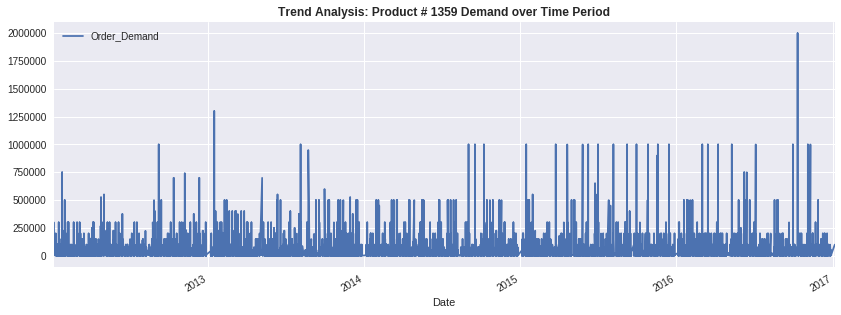

In [16]:
product_1359_df.plot (x = 'Date', y = 'Order_Demand', figsize = (14, 5))
plt.title ('Trend Analysis: Product # 1359 Demand over Time Period', fontweight = 'bold', fontsize = 'large')
plt.show ()

Since some specific dates in the above graph have many values, so we accumulate them in the next step, before analyzing the graph. So, accumulating each dates total order demands and replotting the **demand over time** graph.

In [17]:
print('\n',product_1359_df [product_1359_df ['Date'].duplicated ()].head ())
print('\n')

product_accumulated_1359_df = product_1359_df.groupby ('Date')['Order_Demand'].sum ().to_frame ()
print(product_accumulated_1359_df.head())


        Product_Code Warehouse Product_Category       Date  Order_Demand
63099  Product_1359    Whse_J     Category_019 2012-01-05        5000.0
2577   Product_1359    Whse_J     Category_019 2012-01-05        2000.0
32610  Product_1359    Whse_J     Category_019 2012-01-05       10000.0
46739  Product_1359    Whse_J     Category_019 2012-01-05        5000.0
78867  Product_1359    Whse_J     Category_019 2012-01-05        5000.0


            Order_Demand
Date                    
2012-01-05      702000.0
2012-01-06      676000.0
2012-01-10      783000.0
2012-01-11      200000.0
2012-01-12      284000.0


So, after above date wise aggregation, the second table shows that now we only have **one accumulated value per date** with no **Date** duplicates. Also, the Date feature has now been used as the **Index** for this dataframe.

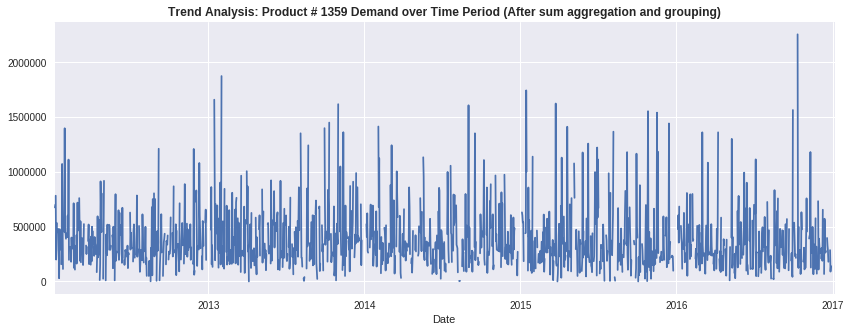

In [18]:
product_accumulated_1359_df ['Order_Demand'].asfreq ('D'). plot (figsize = (14, 5))
plt.title ('Trend Analysis: Product # 1359 Demand over Time Period (After sum aggregation and grouping)', fontweight = 'bold', fontsize = 'large')
plt.show ()

**Inference from Visualization:** Now, we again plot and this time it looks more real world and practical for all date index values, as shown in the above graph. From the above graph, we can see that the **Product # 1359 's demand over time follows almost the same consistent pattern over each year with some spikes occuring at the end months of each year. This looks reasonable as end of year is the shoppping season, thus, justifying these spikes**.

Now, for next three visualizations to seek some trends in the data, we analyze the **Product # 1359 demand** based on some time unit resolution e.g. **Year, Week, Month, Day**. In other words, we want to see when the **demand (trend) for Product # 1359** is higher and at which time the demand is lower and so on. So for that purpose, first we break the Date/Time field into *new features (Year, Month, Week, Day)*.

In [19]:
product_accumulated_1359_df.index = pd.to_datetime (product_accumulated_1359_df.index, errors = 'coerce')
product_accumulated_1359_df ['Year'] = product_accumulated_1359_df.index.year
product_accumulated_1359_df ['Month'] = product_accumulated_1359_df.index.month
product_accumulated_1359_df ['Week'] = product_accumulated_1359_df.index.week
product_accumulated_1359_df ['Day'] = product_accumulated_1359_df.index.weekday
product_accumulated_1359_df.head ()

,Order_Demand,Year,Month,Week,Day
Date,,,,,
2012-01-05,702000.0,2012,1,1,3
2012-01-06,676000.0,2012,1,1,4
2012-01-10,783000.0,2012,1,2,1
2012-01-11,200000.0,2012,1,2,2
2012-01-12,284000.0,2012,1,2,3


Once we have have the new time based features, next we analyze our Product # 1359 demand trend based on these new time units one by one to draw **three compelling visualizations for story-telling**.


### 2) Time Based Analysis on Demand Trend # 01 : Day-of-Week
---

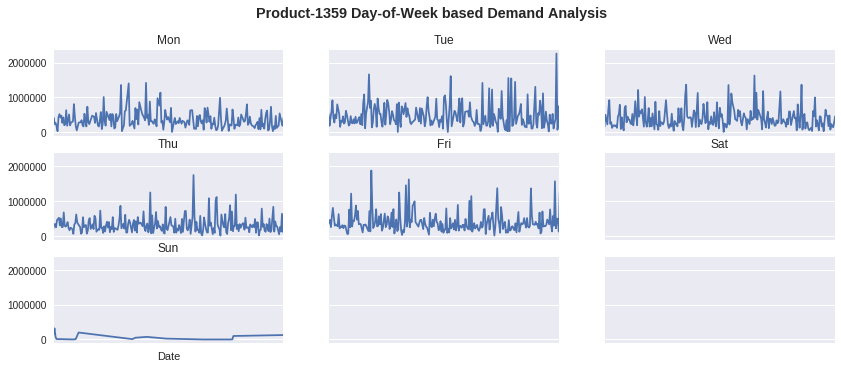

In [20]:
print('\n')
fig, axes = plt.subplots (nrows = 3, ncols = 3, figsize = (14, 6), sharey = True, sharex = True)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for day in range (7):
    product_accumulated_1359_df [product_accumulated_1359_df ['Day'] == day].plot (y = 'Order_Demand', ax = axes [day // 3, day % 3], legend = False, title = days [day])
plt.suptitle ('Product-1359 Day-of-Week based Demand Analysis', fontweight = 'bold', fontsize = 'x-large')
plt.xticks ([])
plt.show ()

**Inference from Visualization:** As clear from the above graphs, there is almost no demand for Product # 1359 on weekend days (Saturdays and Sundays). For remaining days, most high demand peaks are in the **middle section of the days** as expected normally.


### 3) Time Based Analysis on Demand Trend # 02 :  Month-of-Year
---

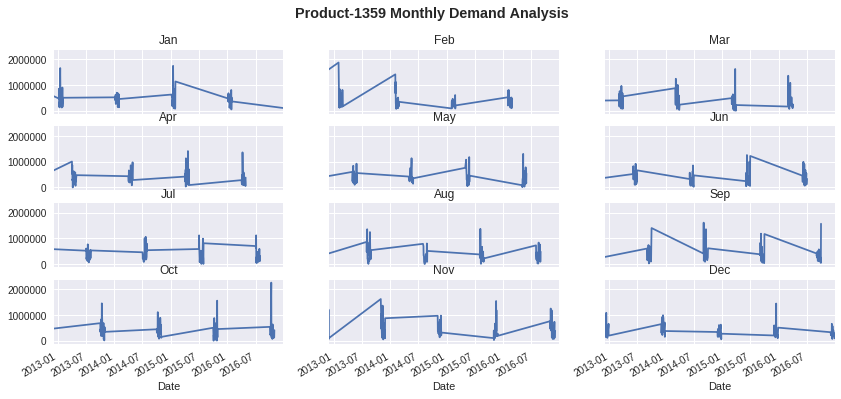

In [21]:
print('\n')
fig, axes = plt.subplots (nrows = 4, ncols = 3, figsize = (14, 6), sharey = True, sharex = True)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month in range (1, 13):
    product_accumulated_1359_df [product_accumulated_1359_df ['Month'] == month]. plot (y = 'Order_Demand', ax = axes [(month - 1) // 3, (month - 1) % 3], legend = False, title = months [month - 1])
plt.suptitle ('Product-1359 Monthly Demand Analysis', fontweight = 'bold', fontsize = 'x-large')
plt.show ()

**Inference from Visualization:** The above monthly demand trend graphs indicate that the demand for the Product # 1359 is almost zero at the end of most of the months (February, March, April, May, June, July, August, September, October, November). So, this non-uniformity can be tricky to handle, if we do not use the month based trends. Thus, monthy trends seem to be providing with very valuable insights about the data. For December and January, the demand is quite good throughout the whole month, which I suppose is, due to the **shopping season**.


### 4) Time Based Analysis on Demand Trend # 03 :  Week-of-Year
---
In the last demand trend analysis, we see the demand trend for each specific week of the year by accumulating all the orders for that week in all years.

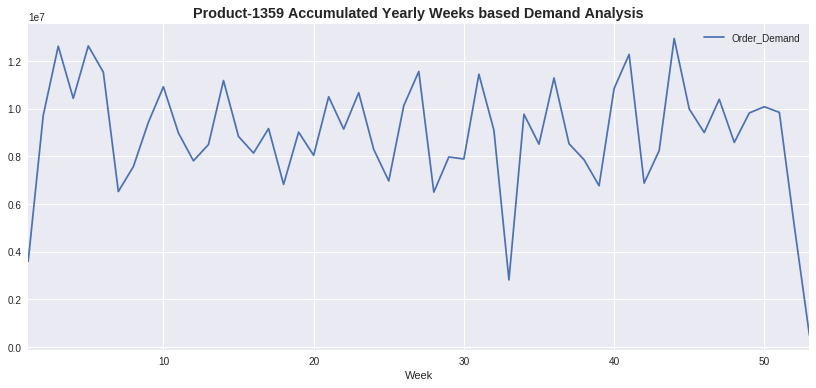

In [22]:
print('\n')
product_accumulated_weekly_1359_df = product_accumulated_1359_df.groupby ('Week')['Order_Demand'].sum ().to_frame ()
product_accumulated_weekly_1359_df.plot (y = 'Order_Demand', figsize = (14, 6))
plt.title ('Product-1359 Accumulated Yearly Weeks based Demand Analysis', fontweight = 'bold', fontsize = 'x-large')
plt.show ()

**Inference from Visualization:** This accumulation based analysis indicates that weekly trend is quite smooth and can be useful for any time based analysis.

## Conclusion


**Story telling and the Data visualization** are the main and vital components that can be considered as the main objective of any data science based explorative analysis. In this project, I learnt about few ways to yield compelling visualizations that can be helpful in telling interesting and valuable story about the data. To get insights into the time-series data, we learnt that some time units (**weekly, monthly, yearly**) are really helpful. Consequently, we analyzed the given dataset using these newly created time based units that gave us valauble insights about the given dataset products. Consequently, we **obtained four compelling visuaizations to tell valuable story about the given datasets products**. I also learnt that **story-telling is art and visualizations can help in demonstrating that art**.


# References

1) https://github.com/Usajid/731_assign5